# Creating a dynamical system

Topics:
* What *is* a dynamical system, for **DynamicalSystems.jl**?
* How to define a discrete or continuous system.
* What is the different handling of large and small systems?
    * Handy Dandy definition table!
* Comment on DifferentialEquations.jl
* Docstrings

---

# `DynamicalSystem`
The functions of **DynamicalSystems.jl** are centered around 2 data structures: 

* Numerical data (`AbstractDataset` instance), shown in the previous tutorial.
* Dynamical systems (`DynamicalSystem` instance). This handles cases where one has *known equations of motion*.


---

For all intents and purposes, a `DynamicalSystem` is a Julia `struct` that contains all the information of a dynamical system:
1. Equations of motion function $\vec{f}$ :  
    * $\frac{d\vec{u}}{dt} = \vec{f}(\vec{u}, t)$ for continuous, or
    * $\vec{u}_{n+1} = \vec{f}(\vec{u}_n, n)$ for discrete systems.
3. Initial condition.
4. Parameter container (if the equations of motion are parameterized).
2. Jacobian of the equations of motion.

# Creating a simple discrete system

For simplicity let's focus on creating a simple discrete chaotic system, the [Hénon map](https://en.wikipedia.org/wiki/H%C3%A9non_map). 

The constructor we need is simply:

```julia
DiscreteDynamicalSystem(eom, state, p)
```

## Equations of motion
A **function** representing the equations of motion is the first argument of the above constructors: `eom`.

Therefore, the first step in creating a `DynamicalSystem` is to define the equations of motion. For the Hénon map they have the form:
$$
\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}
$$

Now we must make a function out of them. There is some strictness when writing this function in Julia. Specifically, it can only be one of two forms: in-place (iip) or out-of-place (iip). Here is how to define it:

* **oop** : The `eom` function **must** be in the form `eom(x, p, t) -> SVector`
  which means that given a state `x::SVector` and some parameter container
  `p` it returns an [`SVector`](http://juliaarrays.github.io/StaticArrays.jl/stable/pages/api.html#SVector-1)
  (from the [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) module)
  containing the next state.
* **iip** : The `eom` function **must** be in the form `eom!(xnew, x, p, t)`
  which means that given a state `x::Vector` and some parameter container `p`,
  it writes in-place the new state in `xnew`.

We advise to use **oop** for systems with dimension < 11, and use **iip** otherwise.

Because the Hénon map only 2-dimensional, we follow the advice of the documentation and take advantage of [`StaticArrays`](https://github.com/JuliaArrays/StaticArrays.jl) module.

* Remember: `DiscreteDynamicalSystem(eom, state, p)`

In [21]:
using DynamicalSystems
h_eom(x, p, t) = SVector{2}(1.0 - p[1]*x[1]^2 + x[2], p[2]*x[1])

h_eom (generic function with 1 method)

* Remember: *both* `p` (for parameters) and `t` (for time) must be included in the equations of motion function, irrespectively of if they are used or not!

The second argument for the `DiscreteDynamicalSystem` constructor is a `state`, which represents the initial condition for the system:

In [18]:
state = zeros(2) # doesn't matter if we use Vector of SVector for the `state`

2-element Array{Float64,1}:
 0.0
 0.0

Then, the last argument, `p`, is simply a parameter container.

In [19]:
p = [1.4, 0.3] # p = [a, b] from the equations

2-element Array{Float64,1}:
 1.4
 0.3

These 3 things are enough to make a `DynamicalSystem`:

In [22]:
henon = DiscreteDynamicalSystem(h_eom, state, p)

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  ForwardDiff


The `show` function nicely summarized the dynamical system components (I'll talk about the `jacobian` later).

## Getting a trajectory

Now that we have created the system, the first (and most basic) thing to do is to simply plot its time evolution and see what it looks like. 

The `trajectory` function is a convenient tool that evolves the system and returns the output at equally spaced time intervals. The call signature is simply:

```julia
trajectory(ds::DynamicalSystem, T [, u]; kwargs...)
```
which evolves a system for total time `T`, optionally starting from a different state `u`.

In [23]:
# trajectory with initial condition
tr = trajectory(henon, 100000)
# trajectory from a different starting point
tr2 = trajectory(henon, 100000, 0.01rand(2))

2-dimensional Dataset{Float64} with 100001 points:
  0.00974741   0.00607608
  1.00594      0.00292422
 -0.413766     0.301783  
  1.0621      -0.12413   
 -0.703408     0.31863   
  0.625933    -0.211023  
  0.240468     0.18778   
  1.10682      0.0721405 
 -0.642946     0.332047  
  0.753317    -0.192884  
  0.0126355    0.225995  
  1.22577      0.00379064
 -1.09973      0.367731  
  ⋮                      
 -0.865947     0.350643  
  0.300833    -0.259784  
  0.613515     0.0902499 
  0.563289     0.184055  
  0.739843     0.168987  
  0.402673     0.221953  
  0.994949     0.120802  
 -0.265092     0.298485  
  1.2001      -0.0795276 
 -1.09587      0.36003   
 -0.321268    -0.328761  
  0.526741    -0.0963805 


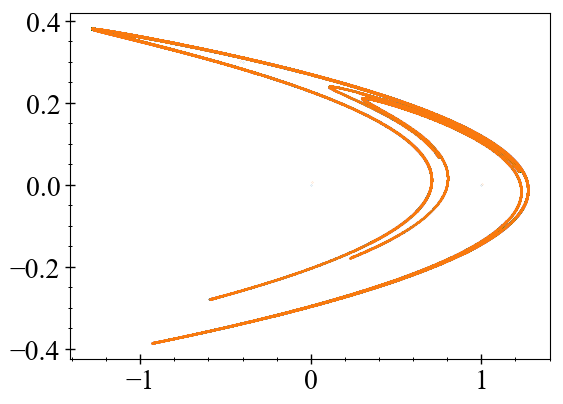

In [25]:
using PyPlot
figure(figsize=(6,4))
plot(tr[:, 1], tr[:, 2], lw = 0.0, marker = "o", ms = 0.1);
plot(tr2[:, 1], tr2[:, 2], lw = 0.0, marker = "o", ms = 0.1);

* Because both starting points fall into an attractor, they cover each other.

# Adding a Jacobian

Let's see `henon` again:

In [26]:
henon

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  ForwardDiff


* The last line, `jacobian:  ForwardDiff`
says that the Jacobian function of the equations of motion was computed automatically using the module [`ForwardDiff`](http://www.juliadiff.org/ForwardDiff.jl/stable/user/api.html). 
* The Jacobian function is a crucial component of a dynamical system, and that is why if it is not given, tit is computed automatically.



Even though the automatic computation is very efficient, the best possible performance will come if you pass a "hard-coded" jacobian:

In [27]:
h_jacobian(x, p, t) = @SMatrix [-2*p[1]*x[1] 1.0; p[2] 0.0]

h_jacobian (generic function with 1 method)

* Notice that for **out-of-place** systems, the Jacobian must also have the same form as the equations of motion, namely to return an `SMatrix`.

Now, we can pass this Jacobian function to the `DiscreteDynamicalSystem` constructor as a 4th argument:

In [28]:
henon_with_jac = DiscreteDynamicalSystem(h_eom, state, p, h_jacobian)

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  h_jacobian


To see the difference in performance, let's evolve the system and its tangent space:

In [29]:
t1 = tangent_integrator(henon, 2)
t2 = tangent_integrator(henon_with_jac, 2)
using BenchmarkTools
# Benchmark how much time does a single "step" take, i.e. evolving
# the system and tangent space for 1 discrete time step
@btime step!($t1)
@btime step!($t2)

  21.759 ns (0 allocations: 0 bytes)
  11.495 ns (0 allocations: 0 bytes)


You can see that even though `ForwardDiff` is truly performant, the hard-coded version is twice as fast.


* (the function `tangent_integrator` is discussed in the ["Advanced Documentation"](https://juliadynamics.github.io/DynamicalSystems.jl/latest/advanced/) page)

# Continuous System
* The process of creating a continuous system is fully identical to that of a discrete system, but the constructor `ContinuousDynamicalSystem` is used instead. 
* Of course, in this case the function `eom` returns the time derivatives and not a "next state".


---



* We will take the opportunity to show the process of using in-place equations of motion for a continuous system, which is aimed to be used for large systems (dimensionality $\ge$ 10).

* In addition, the system we will use (Henon-Heiles) does not have any parameters.

In [30]:
# Henon-heiles famous system
# in-place form of equations of motion
# du is the derivatives vector, u is the state vector
function hheom!(du, u, p, t)
    du[1] = u[3]
    du[2] = u[4]
    du[3] = -u[1] - 2u[1]*u[2]
    du[4] = -u[2] - (u[1]^2 - u[2]^2)
    return nothing
end

# pass `nothing` as the parameters, because the system doesn't have any
hh = ContinuousDynamicalSystem(hheom!, [0, -0.25, 0.42081, 0], nothing)

4-dimensional continuous dynamical system
 state:     [0.0, -0.25, 0.42081, 0.0]
 e.o.m.:    hheom!
 in-place?  true
 jacobian:  ForwardDiff


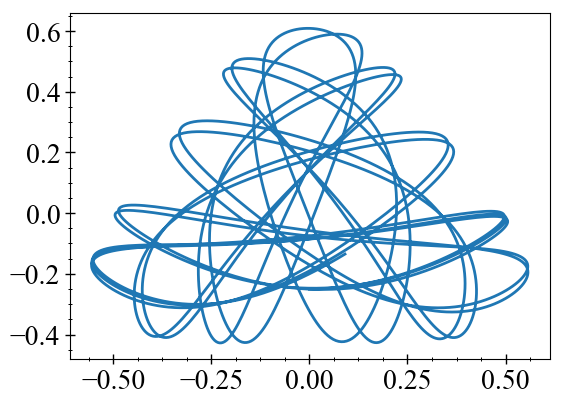

In [31]:
# Evolve the system using DifferentialEquations.jl
tr = trajectory(hh, 100.0, dt = 0.05)

figure(figsize = (6,4))
plot(tr[:, 1], tr[:, 2]);

# Handy Dandy definition table

Depending on whether your system is small or large, you want to use out-of-place or in-place equations of motion. The Jacobian function (if you wish to provide it) must also be of the same form. 

Here is a handy table that summarizes how the definitions should be:

|          System Type         |    equations of motion    |            Jacobian            |
|:----------------------------:|:-------------------------:|:------------------------------:|
| in-place (big systems)       | `eom!(du, u, p, t)`       | `jacobian!(J, u, p, t)`        |
| out-of-place (small systems) | `eom(u, p, t) -> SVector` | `jacobian(u, p, t) -> SMatrix` |


# Time-evolution of systems & DifferentialEquations.jl
Discrete systems are evolved using internal algorithms. However, all time evolution of continuous systems is done through the [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/) library. In fact, `trajectory` for continuous systems simply wraps `solve` with some extra arguments.

Keep in mind that by default all continuous systems are evolved using the solver `Vern9()` (9th order Verner solver) with tolerances `abstol = reltol = 1e-9`. This is especially important when one wants to compare benchmarks with different packages.

## When to use **DynamicalSystems.jl**?
If the *only* thing you care about is evolving a system in time, then you are better off using directly DifferentialEquations.jl (Plus DiffEq has much more stuff besides simply evolving a system)!

* You can still use DifferentialEquations.jl *after* you have defined a continuous dynamical system, because the field `prob` gives an `ODEProblem`:

In [ ]:
hh.prob

**(please be careful when using this problem directly, because as you can see the `tspan[end]` field is `Inf`!)**

**DynamicalSystems.jl** is useful when one wants to calculate quantities useful in nonlinear dynamics and chaos, like all the examples that we will show in the following tutorials.

In addition, we offer specialized integrators that evolve the system and the tangent space, or many states of the system in parallel (at *exactly* same times):
* `tangent_integrator`
* `parallel_integrator`

(more on these integrators in the tutorial "Advanced Usage")

These functions work for both continuous and discrete systems and also work regardless of if the system is in-place (large), out-of-place (small) or auto-differentiated. Special attention has also been given to the performance of the integrators. 

Also, keep in mind that regardless of if you use a `DynamicalSystem` to produce a timeseries or not, more than half of the **DynamicalSystems.jl** library is using numerical data as an input, which most of the time is expected in the form of some `AbstractDataset`, which is what `trajectory` returns.

# Docstrings

In [ ]:
?DynamicalSystem

In [ ]:
?trajectory